In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf

from scipy import io
from scipy.signal import butter, lfilter
import h5py
import random
import numpy as np
import os

import datetime
from time import gmtime, strftime, time

from nd_legacy import *

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ecog_matfile = io.loadmat('test_ecog_data.mat')
raw_data = ecog_matfile['raw_data']
raw_acc = ecog_matfile['raw_acc']
mv_acc = ecog_matfile['mv_acc']

sampling_rate = 2000

raw_data = raw_data[:,0:-10000]
raw_acc = raw_acc[:,0:-10000]
mv_acc = mv_acc[:,0:-10000]

len_raw_data = raw_data.shape[1]

raw_acc_f = butter_bandpass_filter(raw_acc, 0.1, 1, sampling_rate, order=3, how_to_filt = 'separately')


del_1 = len_raw_data//2
del_2 = 3*len_raw_data//4

idxs_train = np.arange(0,del_1);
idxs_val = np.arange(del_1,del_2);
idxs_test = np.arange(del_2,len_raw_data - 1000);

raw_data_train = raw_data[4:8,idxs_train]
raw_data_val = raw_data[4:8,idxs_val]
raw_data_test = raw_data[4:8,idxs_test]

mv_acc_train = raw_acc_f[:,idxs_train]
mv_acc_val = raw_acc_f[:,idxs_val]
mv_acc_test = raw_acc_f[:,idxs_test]

def generate_slice(slice_len, pos=2, val=False):
    if val:
        X = raw_data_val
        y = mv_acc_val
    else:
        X = raw_data_train
        y = mv_acc_train

    len_X = X.shape[1]

    while True:
        slice_start = np.random.choice(len_X - slice_len)
        slice_end = slice_start + slice_len
        slice_mid = slice_start + slice_len//2
        slice_x = X[:,slice_start:slice_end].T

        if pos==0:
            slice_y = y[0,slice_start]
        elif pos==1:
            slice_y = y[0,slice_mid]
        else:            
            slice_y = y[0,slice_end]

        return slice_x, slice_y

def data_generator(batch_size, slice_len, pos=2, val=False):
    while True:
        batch_x = []
        batch_y = []

        for i in range(0, batch_size):
            x, y = generate_slice(slice_len, pos, val=False)
            batch_x.append(x)
            batch_y.append(y)

        y = np.array(batch_y)
        x = np.array([i for i in batch_x])
        yield (x, y)


In [3]:
from keras.layers import Conv1D, Dense, maximum, Dropout, Input, merge, GlobalMaxPooling1D, MaxPooling1D, Flatten, LSTM, BatchNormalization
from keras.models import Model, load_model
from keras.optimizers import RMSprop

from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [4]:
###

slice_len = 2000

nb_filters = 5
kernel_size = 50

pos = 1

###

input_seq = Input(shape=(slice_len, 4))

inputbn = BatchNormalization()(input_seq)

convolved = Conv1D(nb_filters, kernel_size=500, padding="same", activation='elu', kernel_initializer='orthogonal')(inputbn)
convolvedbn = BatchNormalization()(convolved)
pooled = MaxPooling1D(pool_size=4)(convolvedbn)

convolved2 = Conv1D(nb_filters*4, kernel_size=250, padding="same", activation='elu', kernel_initializer='orthogonal')(pooled)
convolved2bn = BatchNormalization()(convolved2)
pooled2 = MaxPooling1D(pool_size=4)(convolved2bn)

convolved3 = Conv1D(nb_filters*16, kernel_size=kernel_size, padding="same", activation='elu', kernel_initializer='orthogonal')(pooled2)
convolved3bn = BatchNormalization()(convolved3)
pooled3 = MaxPooling1D(pool_size=4)(convolved3bn)

convolved4 = Conv1D(nb_filters*64, kernel_size=kernel_size, padding="same", activation='elu', kernel_initializer='orthogonal')(pooled3)
convolved4bn = BatchNormalization()(convolved4)

flat = GlobalMaxPooling1D()(convolved4bn)

dense1 = Dense(256, activation='elu', kernel_initializer='glorot_normal')(flat)
dense1 = BatchNormalization()(dense1)
dense1 = Dropout(0.2)(dense1)

dense2 = maximum([Dense(64, activation='elu', kernel_initializer='glorot_normal')(dense1) for _ in range(2)])
dense2 = BatchNormalization()(dense2)
dense2 = Dropout(0.2)(dense2)

out = Dense(1, activation='linear')(dense2) 
model = Model(inputs=input_seq, outputs=out)

###

model.compile(loss="mse", optimizer="adagrad", metrics=["mse"])

##

path_to_save_model = "1511_2_pos1"

steps_per_epoch = 600
validation_steps = 300
epochs = 200
patience = 10

batch_size = 32

earlyStopping = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(path_to_save_model, monitor='val_loss', verbose=1,
                               save_best_only=True, mode='auto', period=1)


model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 2000, 4)       0                                            
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 2000, 4)       16          input_1[0][0]                    
____________________________________________________________________________________________________
conv1d_1 (Conv1D)                (None, 2000, 5)       10005       batch_normalization_1[0][0]      
____________________________________________________________________________________________________
batch_normalization_2 (BatchNorm (None, 2000, 5)       20          conv1d_1[0][0]                   
___________________________________________________________________________________________

In [ ]:
model.fit_generator(data_generator(slice_len=slice_len, batch_size=batch_size, pos=pos), 
                    steps_per_epoch=steps_per_epoch, 
                    epochs=epochs, 
                    callbacks=[earlyStopping, checkpointer], verbose=1, 
                    validation_steps=validation_steps, 
                    validation_data=data_generator(slice_len=slice_len, batch_size=batch_size, pos=pos, val=True))

Epoch 1/200
600/600 [==============================] - 38s - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 6.9971e-04 - val_mean_squared_error: 6.9971e-04
Epoch 2/200
600/600 [==============================] - 36s - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 7.1208e-04 - val_mean_squared_error: 7.1208e-04
Epoch 3/200
233/600 [==========>...................] - ETA: 19s - loss: 0.0010 - mean_squared_error: 0.0010

In [9]:
score, acc = model.evaluate_generator(data_generator(slice_len=slice_len, batch_size=batch_size, 
                                                     pos=pos, val=True),500)

In [10]:
score

0.00025752186254248956

In [11]:
acc

0.00025752186254248956

In [ ]:
model = load_model(path_to_save_model)

In [11]:
score, acc = model.evaluate_generator(data_generator(slice_len=slice_len, batch_size=batch_size, pos=pos, val=True),500)

In [12]:
slice_len = 2000

len_test = raw_data_test.shape[1]
idxs = np.arange(0,len_test - slice_len,10)

txs_0 = np.zeros([idxs.shape[0],slice_len,4])
tys_0 = np.zeros([idxs.shape[0],1])

k = 0

for i in np.arange(0,len_test - slice_len,10):
    slice_start = i
    slice_end = slice_start + slice_len
    slice_x = raw_data_test[:,slice_start:slice_end].T
    
    if pos==0:
        slice_y = mv_acc_test[0,slice_start]
    elif pos==1:
        slice_y = mv_acc_test[0,slice_mid]
    else:            
        slice_y = mv_acc_test[0,slice_end]
    
    txs_0[k] = slice_x
    tys_0[k] = slice_y
    
    k = k+1

0.539467071398
0.752660275868
0.74455973182


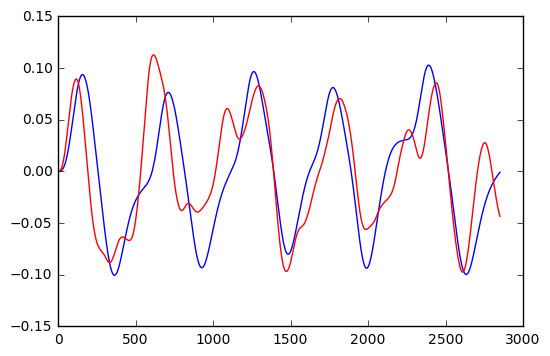

In [21]:
tys_pred = model.predict(txs_0)

tys_0_f = butter_bandpass_filter(tys_0.T, 0.5, 20, sampling_rate, order=3, how_to_filt = 'simultaneously').T

#tys_0_f = tys_0
tys_pred_f = butter_bandpass_filter(tys_pred.T, 0.5, 10, sampling_rate, order=3, how_to_filt = 'simultaneously').T

plt.clf()
plt.plot(tys_0,'g')
plt.plot(tys_0_f,'b')
#plt.savefig(figure_name+'true')

plt.clf()
plt.plot(tys_pred,'g')
plt.plot(tys_pred_f,'b')
#plt.savefig(figure_name+'pred')

plt.clf()
plt.plot(tys_0_f,'b')
plt.plot(tys_pred_f,'r')
#plt.savefig(figure_name+'comp')

cor = np.corrcoef(tys_0[:,0],tys_pred[:,0])
cor = cor[0,1]

cor_smooth = np.corrcoef(tys_0_f[:,0],tys_pred_f[:,0])
cor_smooth = cor_smooth[0,1]

cor_sm_pred_only = np.corrcoef(tys_0[:,0],tys_pred_f[:,0])
cor_sm_pred_only = cor_sm_pred_only[0,1]

print(cor)
print(cor_smooth)
print(cor_sm_pred_only)